<a target="_blank" href="https://colab.research.google.com/github/retowuest/uio-dl-2024/blob/main/Notebooks/nb-3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Learning for Social Scientists

### University of Oslo, November 27-28, 2024

### **Demo 4:**<br>Convolutional Neural Networks (CNNs)

### Table of Contents
* [Introduction](#section_1)
* [Loading the Data](#section_2)
* [Data Augmentation](#section_3)
* [Training a CNN Smile Classifier](#section_4)

### Introduction <a class="anchor" id="section_1"></a>

In this demo, we will use [PyTorch](https://pytorch.org/) to build a convolutional neural network (CNN) for smile classification of face images. We will distinguish between the classes *smile* and *not smile*, so this is a binary classification task.

We will use the **CelebA** data set provided by [Torchvision](https://pytorch.org/vision/stable/index.html). Information about this data set is available [here](https://pytorch.org/vision/stable/datasets.html#celeba). The data set contains 202,599 images of celebrities' faces. It also contains 40 binary facial attributes for each image, including whether a celebrity is smiling or not.

Our goal is to build and train a CNN model for predicting the smile attribute from the face images. For simplicity, we will only be using a small portion of the training data (16,000 training examples) to speed up the training process. However, to reduce overfitting on such a small data set and improve generalization performance, we will use a technique called [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation).

### Loading the Data <a class="anchor" id="section_2"></a>

Let's first load the data. The **CelebA** data set comes with three partitions:

- a training set,
- a validation set,
- and a test set.

Set the argument `split` to one of {"train", "valid", "test"} to download the corresponding set.

Note that to download the **CelebA** dataset [gdown](https://github.com/wkentaro/gdown) is required, so we install it in the cell below.

In [ ]:
%%capture

!pip3 install gdown

In [ ]:
# The goal is to tell whether a person is smiling or not
# Import torchvision library
import torchvision

# Set the root of the folder that should contain
# the data (I'm choosing the parent directory of
# the directory that hosts the notebook on my
# local machine)
image_path = "../"

# Download the three partitions of the CelebA
# data set: train, valid, and test
# (If you download the files with torchvision,
# set download=True in the below code snippets;
# if the data are already downloaded, they are
# not downloaded again)
celeba_train = torchvision.datasets.CelebA(
    image_path, split="train",
    target_type="attr", download=True
)

celeba_valid = torchvision.datasets.CelebA(
    image_path, split="valid",
    target_type="attr", download=True
)

celeba_test = torchvision.datasets.CelebA(
    image_path, split="test",
    target_type="attr", download=True
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's count the number of examples in each partition.

In [ ]:
# Count number of examples in each partition
print("Train set:", len(celeba_train))
print("Validation set:", len(celeba_valid))
print("Test set:", len(celeba_test))

Train set: 162770
Validation set: 19867
Test set: 19962


### Data Augmentation <a class="anchor" id="section_3"></a>

Data augmentation summarizes a set of techniques we can use to deal with cases where the training data are limited. These techniques allow us to modify data, or even artificially synthesize data, and thereby improve the performance of a machine learning or deep learning model by reducing overfitting. For our image data, we will employ two different types of transformations available from the `torchvision.transforms` module:
- cropping an image to a bounding box;
- flipping an image horizontally.

These cropped and flipped images become new data points in the training set, thereby increasing the size of training set

We apply the above transformations in a random fashion. This means that we crop an image to a random bounding box and flip it randomly along the horizontal axis. We create a pipeline for these transformations, which we will use during the data set loading step. In addition, we define a [lambda function](https://realpython.com/python-lambda/) called `get_smile`, which will extract the `Smiling` label from the `attributes` list in the data set (note that the `Smiling` label is the 32nd attribute).

In [ ]:
# Import transforms module from torchvision library
from torchvision import transforms

# Define a (lambda) function to extract the Smiling label from the attributes list
# (note that because of zero indexing, which means that indexing starts
# at 0, we select the attribute with index 31).
# A lambda function is an anonymous, inline function in Python. It's commonly
# used for short, simple operations
get_smile = lambda attr: attr[31]

# Define function to transform the image
# (we first randomly crop the image, then flip it randomly, and finally,
# resize it to a common size of 64x64)
transform_train = transforms.Compose([  # the Compose method composes several transformations (provided as a list) together
    transforms.RandomCrop([178, 178]),  # randomly crop image to a size of 178x178 pixels
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally with a 0.5 probability
    transforms.Resize([64, 64]),  # resize image to common size of 64x64 pixels
    transforms.ToTensor(),  # convert the image form PIL to tensor
])

We will apply the data augmentation transformations only to the training set and not to the validation and test sets. For the validation and test sets, we will simply crop and resize the images (so that the images from all three sets have the same size).

In [ ]:
# Apply transform_train function to training data set
celeba_train = torchvision.datasets.CelebA(
    image_path, split="train",
    target_type="attr", download=False,
    transform=transform_train,
    target_transform=get_smile  # apply get_smile transformation to the target (attribute vector), which will extract the Smiling attribute
)

To illustrate how the transformations work, we apply them five times to each of two training examples and show the results.

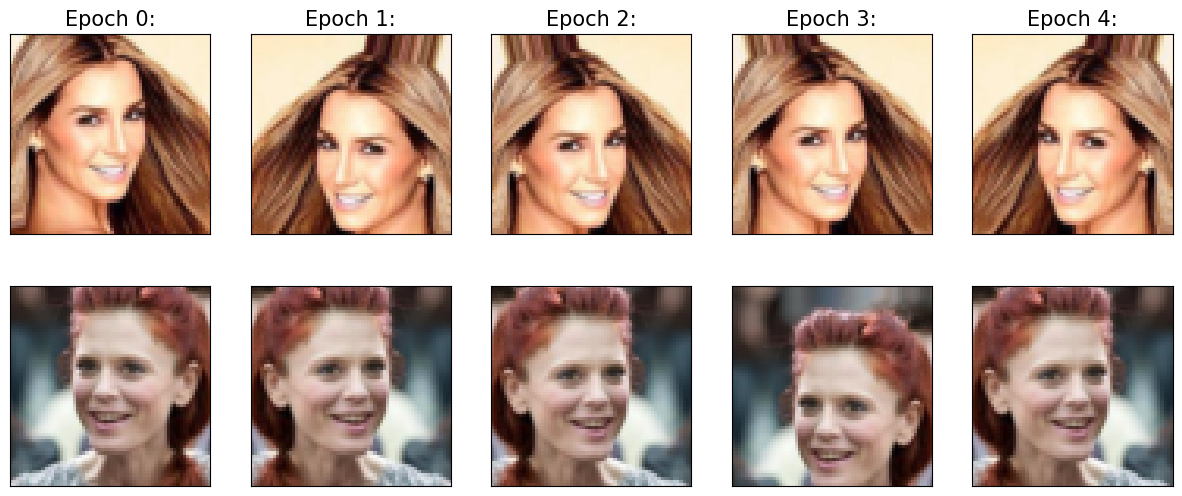

In [ ]:
# Import torch library, pyplot module from matplotlib library,
# and DataLoader class from module torch.utils.data
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Set seed
torch.manual_seed(1)

# Define Dataloader
data_loader = DataLoader(celeba_train, batch_size=2)  # each call to next(iter(data_loader)) will yield a batch of 2 images and their labels

# Apply Dataloader five times and create figure showing results
fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))  # iter(): convert data_loader into an interator that allows us to iterate over the data batches. next(): fetches the next data batch from iterator
    img = img_batch[0]  # extract first image
    ax = fig.add_subplot(2, 5, j + 1)  # numbers 2 (rows) and 5 (columns) refer to the 2x5 grid of subplot; j refers to index of the grid (first index is 1, so we add +1 to j, which starts at 0)
    ax.set_xticks([])  # remove x-axis ticks
    ax.set_yticks([])  # remove y-axis ticks
    ax.set_title(f'Epoch {j}:', size=15)  # add title w/ corresponding epoch number
    ax.imshow(img.permute(1, 2, 0))  # rearranges image dimensions to the format expected by Matplotlib

    img = img_batch[1]  # extract second image
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])  # remove x-axis ticks
    ax.set_yticks([])  # remove y-axis ticks
    ax.imshow(img.permute(1, 2, 0))  # rearranges image dimensions to the format expected by Matplotlib

plt.show();

Next, we will define a separate function `transform`, which crops and resizes images to the desired size of 64x64, and apply this function to our validation and test sets.

In [ ]:
# Define function to crop and resize image
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

# Apply transform function to validation and test sets
celeba_valid = torchvision.datasets.CelebA(
    image_path, split="valid",
    target_type="attr", download=False,
    transform=transform, target_transform=get_smile
)

celeba_test = torchvision.datasets.CelebA(
    image_path, split="test",
    target_type="attr", download=False,
    transform=transform, target_transform=get_smile
)

Finally, rather than using all of the available training and validation data, we will take a subset of 16,000 training examples and 1,000 validation examples (we intentionally train our model on a small data set using data augmentation).

In [ ]:
# Import Subset class from module torch.utils.data
from torch.utils.data import Subset

# Pass original training and validation sets as well as the indices of the examples we want to keep
celeba_train = Subset(celeba_train,
                      torch.arange(16000))

celeba_valid = Subset(celeba_valid,
                      torch.arange(1000))

# Print length of the reduced training and validation sets
print("Train set:", len(celeba_train))
print("Validation set:", len(celeba_valid))

Train set: 16000
Validation set: 1000


Now we can create data loaders for the three data sets.

In [ ]:
# Specify batch size
# (values for batch size are typically provided as a power of two so that
# fit nicely into the memory requirements of the GPU or CPU hardware, like
# 32, 64, 128, 256, etc.
# GPUs, and even CPUs, are optimized for operations involving powers of two)
batch_size = 32

# Set seed
torch.manual_seed(1)

# Create data loaders
train_dl = DataLoader(celeba_train,
                      batch_size,  # when iterating through the data set, each iteration will return specified batch size
                      shuffle=True)  # if argument shuffle=True, then examples are reshuffled

valid_dl = DataLoader(celeba_valid,
                      batch_size,
                      shuffle=False)

test_dl = DataLoader(celeba_test,
                     batch_size,
                     shuffle=False)

Now that the data loaders are ready, we can develop our CNN model and train and evaluate it on the data.

### Training a CNN Smile Classifier <a class="anchor" id="section_4"></a>

We build our CNN model with the `torch.nn` module. We will use the class [`nn.Sequential`](https://pytorch.org/docs/main/generated/torch.nn.Sequential.html#sequential), which is a sequential container. This means that modules are added in the order they are passed in the constructor.

The network architecture is as follows.

- The CNN model receives input images of size 3x64x64 (the images have three color channels red, green, and blue, and there are 64 by 64 pixels).
- The input data go through four convolution layers with a kernel size of 3x3 and padding of 1 (i.e., we add one row of zeros on the top and bottom and one column of zeros on the left and right). The first convolutional layer produces 32 channels, the second 64 channels, the third 128 channels, and the fourth 256 channels.
- The first three convolution layers are followed by max-pooling, $P_{2 \times 2}$ (see Prince 2024, 171f.).
- Two dropout layers are also included for regularization (dropout randomly clamps a subset, typically 50%, of hidden units to zero; see Prince 2024, 147ff.).

In [ ]:
# Import torch.nn module
import torch.nn as nn

# Build CNN model
model = nn.Sequential()  # sequential container

# It's a good practice to name the modules, e.g., conv1, relu1 for debugging & readability
model.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout1", nn.Dropout(p=0.5))

model.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout2", nn.Dropout(p=0.5))

model.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module("relu3", nn.ReLU())
model.add_module("pool3", nn.MaxPool2d(kernel_size=2))

model.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module("relu4", nn.ReLU())

To see the shape of the output, let's apply these layers using a toy batch input of four images.

In [ ]:
# Create toy batch input
# (4 - batch size, i.e., four "images",
# 3 - number of channels, i.e., three for RGB,
# 64 - height of image, i.e., 64 pixels,
# 64 - width of image, i.e., 64 pixels)
x = torch.ones((4, 3, 64, 64))

# Apply the layers and print the shape of the output
model(x).shape

# 4 is the number of images
# 256 is the number of channels of output layer
# 8 is the height & weight of output image

torch.Size([4, 256, 8, 8])

We can see that there are 256 channels of size 8x8 (the first element in `torch.Size([4, 256, 8, 8])` refers to the batch size).

We could now add a fully connected layer to get to the output layer with a single unit. However, the number of input units to this fully connected layer would be 8 $\times$ 8 $\times$ 256 $=$ 16,384.

Alternatively, let's add another layer called *global average-pooling*, which computes the average of each channel separately, and each chanel has 8x8 values. Global average-pooling is very similar to average-pooling: in fact, it is a special case of average-pooling with the pooling size set equal to the size of a channel. Adding such a global average-pooling layer will reduce the number of hidden units to 256. We can then add a fully connected layer.

After applying the global average-pooling layer (and after squeezing with `nn.Flatten`), we expect the output to have size [*batch size*x256].

In [ ]:
# Add global average-pooling layer to model
model.add_module("pool4", nn.AvgPool2d(kernel_size=8))
model.add_module("flatten", nn.Flatten())

# Apply layers again to our toy batch input and print shape of the output
model(x).shape

torch.Size([4, 256])

Finally, we can now add a fully connected layer to get a single output unit. Here we specify the activation function to be sigmoid in order to obtain a probability bounded between 0 and 1.

In [ ]:
# Add fully-connected layer and sigmoid activation function
model.add_module("fc", nn.Linear(256, 1))
model.add_module("sigmoid", nn.Sigmoid())

# Apply layers again to our toy batch input and print shape of the output
model(x).shape

torch.Size([4, 1])

We can also take a look at the network architecture.

In [ ]:
# Show model
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The next step is to choose a loss function and an optimizer.

For binary classification, we can use the binary cross-entropy loss function (`nn.BCELoss`) (the binary cross-entropy loss function is the negative log-likelihood for a Bernoulli distribution with a sigmoid function for the distribution parameter to ensure that it lies in [0, 1], see Prince 2024, 66).

As our optimizer, we choose to use the Adam optimizer (see Prince 2024, 88ff.).

In [ ]:
# Select device
device = torch.device("cpu")
model = model.to(device)

In [ ]:
# Specify loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We can now train the model (for 30 epochs) and use the validation set that we created for monitoring the learning process.

In [ ]:
# Define function for model training
def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs  # list for the training loss after each epoch
    accuracy_hist_train = [0] * num_epochs  # list for the training accuracy after each epoch
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        # Set the model to training mode
        # (Difference between model.train() mode and model.eval() mode is related to how
        # certain layers and operations in the model behave during training and evaluation/testing.
        # E.g., dropout layers are turned on in model.train() mode but turned off in model.eval()
        # mode)
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)  # to ensure that both the model and the data are on the same device
            y_batch = y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()  # uses backpropagation to compute the current gradients
            optimizer.step()  # updates the parameters based on the gradients
            optimizer.zero_grad()  # resets gradients to zero
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)  # loss.item() returns the average loss for the current batch; purpose of multiplying by y_batch.size(0) is to get the total loss for the batch so that we can accumulate the total loss for the entire epoch
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)  # computes the average loss per sample across the entire epoch
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():  # disables gradient computation
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

# Train model
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5126 val_accuracy: 0.5140
Epoch 2 accuracy: 0.5288 val_accuracy: 0.5570
Epoch 3 accuracy: 0.5548 val_accuracy: 0.5560
Epoch 4 accuracy: 0.6064 val_accuracy: 0.5900
Epoch 5 accuracy: 0.6306 val_accuracy: 0.6180
Epoch 6 accuracy: 0.6520 val_accuracy: 0.6620
Epoch 7 accuracy: 0.6691 val_accuracy: 0.6310
Epoch 8 accuracy: 0.6771 val_accuracy: 0.6660
Epoch 9 accuracy: 0.6895 val_accuracy: 0.6140
Epoch 10 accuracy: 0.7115 val_accuracy: 0.6610
Epoch 11 accuracy: 0.7326 val_accuracy: 0.6890
Epoch 12 accuracy: 0.7662 val_accuracy: 0.8220
Epoch 13 accuracy: 0.7852 val_accuracy: 0.8050
Epoch 14 accuracy: 0.8163 val_accuracy: 0.7990
Epoch 15 accuracy: 0.8237 val_accuracy: 0.8520
Epoch 16 accuracy: 0.8394 val_accuracy: 0.8700
Epoch 17 accuracy: 0.8475 val_accuracy: 0.8800
Epoch 18 accuracy: 0.8554 val_accuracy: 0.8440
Epoch 19 accuracy: 0.8564 val_accuracy: 0.8820
Epoch 20 accuracy: 0.8584 val_accuracy: 0.8790
Epoch 21 accuracy: 0.8649 val_accuracy: 0.8820
Epoch 22 accuracy: 0.8

Let's visualize the learning curve and look at the training and validation loss and accuracy after each epoch.

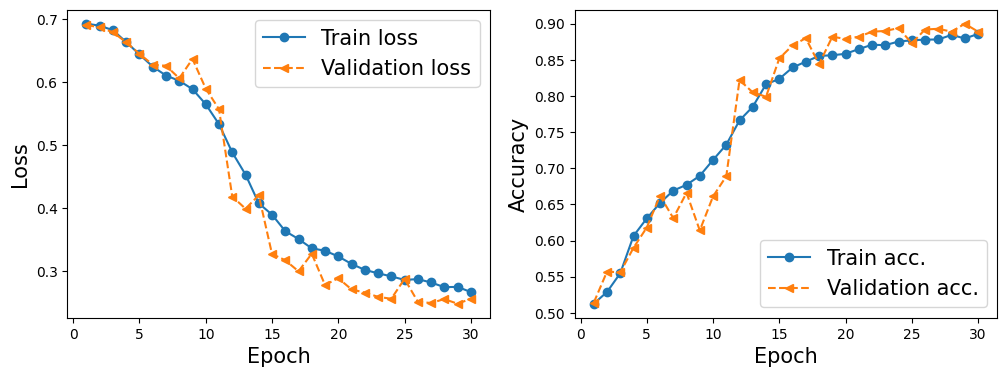

In [ ]:
# Import numpy library
import numpy as np

# Define x-axis
x_arr = np.arange(len(hist[0])) + 1

# Create figure
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1) # 1x2 grid, first subplot for showing loss
ax.plot(x_arr, hist[0], "-o", label="Train loss")
ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)

ax = fig.add_subplot(1, 2, 2) # 1x2 grid, second subplot for showing accuracy
ax.plot(x_arr, hist[2], "-o", label="Train acc.")
ax.plot(x_arr, hist[3], "--<", label="Validation acc.")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)

plt.show();

We can next evaluate the model on the hold-out test set.

In [ ]:
# Initialize container for test accuracy
accuracy_test = 0

# Apply model to test set
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9042


Finally, we take a subset of 10 examples from the last batch of our test set. For this subset, we compute the probability of each example being from class 1 (i.e., class *smile*) and visualize the examples along with their ground truth label and the predicted probability.

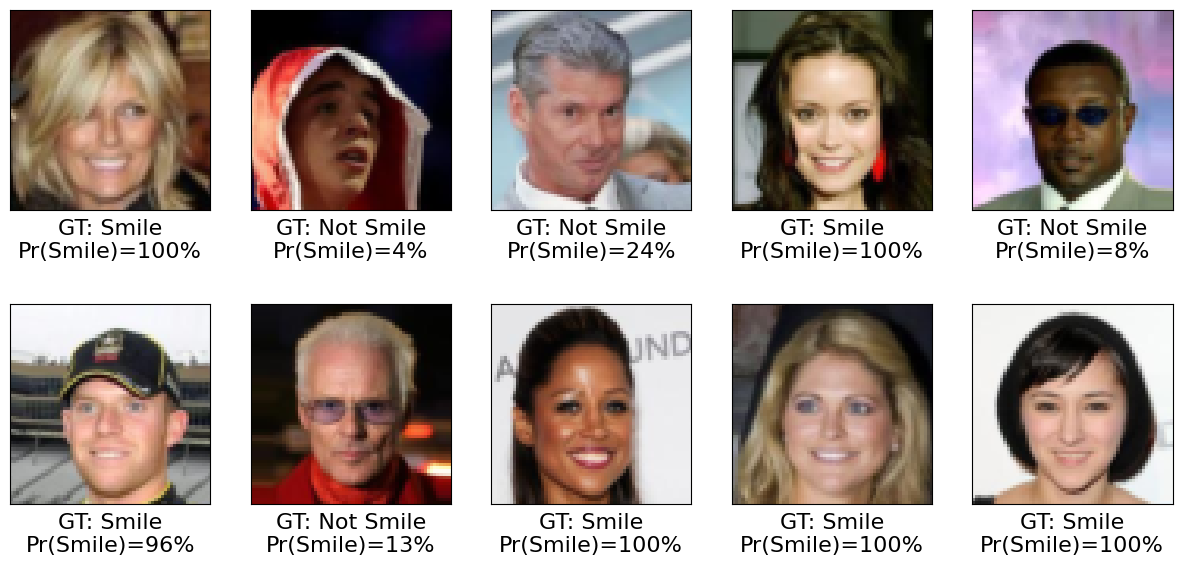

In [ ]:
# Obtain model predictions for the last batch
pred = model(x_batch)[:, 0] * 100

# Create figure
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = "Smile"
    else:
        label = "Not Smile"
    ax.text(
        0.5, -0.15,
        f"GT: {label:s}\nPr(Smile)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes)

plt.show();

As we can see, our trained CNN model is very accurate on this subset of 10 test examples.